# Analyze *falcon* clusters

This notebook can be used to analyze clusters generated by *falcon*.

In [1]:
import time
import csv
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus

from ms_io import ms_io

### Open the file and show basic stats

In [2]:
file = "../work_dir_SSD/Prot_01/clusters.csv"
df = pandas.read_csv(file)
clustMask = df['cluster'] != -1
clustDf = df[clustMask]
nClusteredSp = len(clustDf)
nClusters = np.max(clustDf['cluster']) + 1

print("Number of (non filtered) input spectra: {}".format(len(df)))
print("Number of clustered spectra: {}".format(nClusteredSp))
print("Number of clusters: {}".format(nClusters))
print("Spectra per cluster: {}".format(nClusteredSp/nClusters))

Number of (non filtered) input spectra: 457077
Number of clustered spectra: 34519
Number of clusters: 13337
Spectra per cluster: 2.5882132413586265


### Analyze the n first clusters

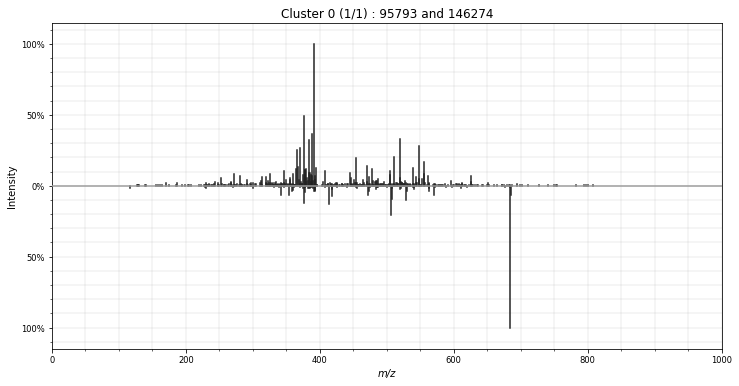

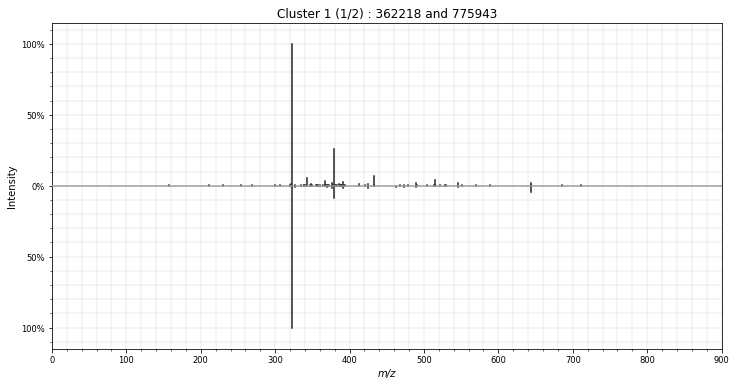

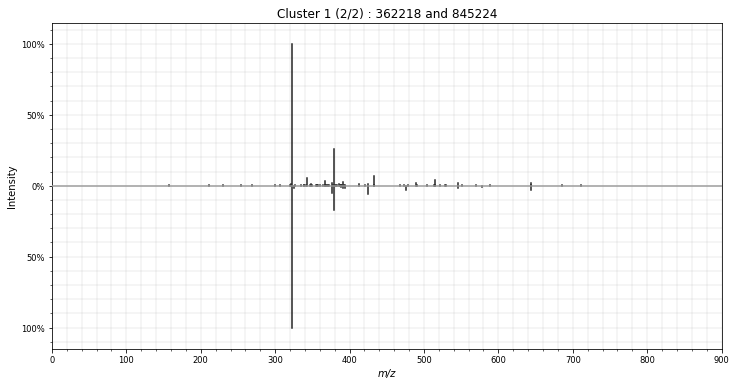

In [3]:
def extract_pkey(str):
    m = re.search('^.+:([0-9]+)+$', str)
    return int(m.group(1))

dbPath = "../datasets/CCLE_MS2.db"

for i in range(0,2):
    #print("### Cluster {} ###".format(i))
    currDf = clustDf[clustDf.cluster == i]
    sps = currDf.loc[:,"identifier"].tolist()

    spf_pkey = extract_pkey(sps[0])
    spf = ms_io.get_one_spectrum(dbPath, spf_pkey)
    for j in range(1, len(sps)):
        fig, ax = plt.subplots(figsize=(12, 6))
        pkey_j = extract_pkey(sps[j])
        spectrum_top, spectrum_bottom = spf, ms_io.get_one_spectrum(dbPath, pkey_j)
        ax.set_title("Cluster {} ({}/{}) : {} and {}".format(i, j, len(sps)-1, spf_pkey, pkey_j))
        sup.mirror(spectrum_top, spectrum_bottom, ax=ax)
        plt.show()
        plt.close()